Imports

In [1]:
import torch    # permet calculs pour les neuronnes 
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments    #bibliothèque d'Hugging Face
from datasets import Dataset      # optimiser les données 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import json
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\alcaz\OneDrive - Toulouse3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration

In [ ]:
BASE_PATH = "../Data/"
REVIEWS_FILE = "yelp_academic_reviews4students.jsonl"
MODEL_NAME = "google-bert/bert-base-uncased" # Modele bert 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Préparation des données

In [3]:
data = [] # Liste pour stocker les dictionnaires JSON
path = r"C:\Users\alcaz\OneDrive - Toulouse3\Semestre6\S6.C.01\SAE\Data\yelp_academic_reviews4students.jsonl"

print("Lecture du fichier...")
with open(path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line)) # Conversion de chaque ligne JSON en dict python

df_all = pd.DataFrame(data) # Création du DataFrame global

def labeler(s):
    if s > 3: return 1 # Positif
    if s < 3: return 0 # Négatif
    return 2           # Neutre

df_all['label'] = df_all['stars'].apply(labeler) # Application des étiquettes

# Détermination du nombre d'avis par classe pour un équilibrage parfait
n_min = df_all['label'].value_counts().min()
print(f"Équilibrage à {n_min} avis par classe (Total: {n_min*3})")
# Cellule : Préparation des données (BERT)
N_TOTAL = 20000
N_PER_CLASS = N_TOTAL // 3 # Soit 6666 avis par classe

df_balanced = pd.concat([
    df_all[df_all['label'] == 0].sample(N_PER_CLASS, random_state=42),
    df_all[df_all['label'] == 1].sample(N_PER_CLASS, random_state=42),
    df_all[df_all['label'] == 2].sample(N_PER_CLASS, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset BERT réduit à {len(df_balanced)} lignes ({N_PER_CLASS} par classe).")

full_dataset = Dataset.from_pandas(df_balanced[['text', 'label']])
full_dataset = full_dataset.train_test_split(test_size=0.1)

Lecture du fichier...
Équilibrage à 98714 avis par classe (Total: 296142)
Dataset BERT réduit à 19998 lignes (6666 par classe).


Tokenisation

In [4]:
# Chargement du tokenizer spécifique à l'architecture BERT (base-uncased)
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME) # Récupère les règles de découpage WordPiece

def tokenize_full(examples):
    # Transformation du texte brut en tenseurs compréhensibles par BERT
    # padding="max_length" : uniformise la taille à 128 (ajoute des zéros)
    # truncation=True : coupe les avis dépassant 128 jetons pour éviter l'explosion mémoire
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# batched=True : traite les lignes par groupes pour optimiser la vitesse de calcul
tokenized_full = full_dataset.map(tokenize_full, batched=True)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 8602.09 examples/s]


Initiation du modéle 

In [5]:
# BertForSequenceClassification : Version de BERT avec une tête de classification linéaire ajoutée
# num_labels=3 : Modifie la couche de sortie (tête) pour passer de 2 à 3 classes (Positif, Négatif, Neutre)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

# Transfert de l'intégralité des paramètres du modèle (environ 110 millions) sur le GPU (cuda)
# Crucial pour BERT car l'entraînement sur CPU est mathématiquement trop lent
model.to(device)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 401.61it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: google-bert/bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSI

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Fonction de Calcul des Métriques

In [6]:
def compute_metrics(pred):
    labels = pred.label_ids # Récupère les étiquettes réelles du dataset de test
    # Applique argmax sur la dernière dimension pour transformer les logits en classe (0, 1 ou 2)
    preds = pred.predictions.argmax(-1) 
    # Calcul des scores. average='weighted' prend en compte le support de chaque classe
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds) # Calcul du taux de prédiction correcte global
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

Configuration de l'Entraînement

In [7]:
training_args = TrainingArguments(
    output_dir="./results_bert_full", # Répertoire de sauvegarde des checkpoints
    num_train_epochs=3,               # Nombre de passages complets sur les données
    per_device_train_batch_size=16,   # Taille du lot par GPU (ajusté pour la VRAM)
    # Multiplication du batch effectif sans augmenter la mémoire (16 * 2 = 32)
    gradient_accumulation_steps=2,    
    learning_rate=2e-5,               # LR très bas pour ne pas détruire les poids pré-entraînés
    fp16=True,                        # Utilise la précision demi-flottante (accélère le calcul sur GPU)
    eval_strategy="steps",            # Déclenche l'évaluation tous les X pas (steps)
    eval_steps=500,                   # Fréquence de test sur le dataset de validation
    save_steps=500,                   # Fréquence de sauvegarde du modèle
    save_total_limit=2,               # Garde seulement les 2 meilleurs modèles pour économiser le stockage
    load_best_model_at_end=True,      # Recharge automatiquement le modèle le plus performant en fin de cycle
    logging_steps=100,                # Fréquence d'affichage de la loss dans la console
    report_to="none"                  # Désactive les rapports externes (type WandB)
)

Le Trainer et le Lancement

In [8]:
# Initialisation du moteur d'entraînement
trainer = Trainer(
    model=model,                      # Modèle BERT chargé en mémoire
    args=training_args,               # Hyperparamètres (Batch size, LR, etc.)
    train_dataset=tokenized_full["train"], # 90% des données
    eval_dataset=tokenized_full["test"],   # 10% des données pour validation
    compute_metrics=compute_metrics   # Calcul Accuracy/F1 pendant l'entraînement
)

# Vérification matérielle avant lancement
if training_args.device.type == 'cuda':
    # Affiche le nom de la carte (ex: RTX 2070) pour confirmer l'accélération matérielle
    print(f"Début de l'entraînement sur GPU  : {torch.cuda.get_device_name(0)}...")
else:
    # Alerte critique : BERT sur CPU peut prendre des jours là où le GPU prend des minutes
    print("Début de l'entraînement sur CPU (Attention : cela sera lent)...")

# Lancement de la boucle d'optimisation
trainer.train()

Début de l'entraînement sur GPU  : NVIDIA GeForce RTX 2070 SUPER...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,1.006206,0.469347,0.807000,0.809850,0.816280,0.807000
1000,0.834029,0.470801,0.810500,0.808790,0.808393,0.810500
1500,0.612569,0.486464,0.815000,0.816235,0.818098,0.815000


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer

TrainOutput(global_step=1689, training_loss=0.8632259470531403, metrics={'train_runtime': 345.605, 'train_samples_per_second': 156.23, 'train_steps_per_second': 4.887, 'total_flos': 3551636469201408.0, 'train_loss': 0.8632259470531403, 'epoch': 3.0})

Evaluation


--- RAPPORT DE CLASSIFICATION BERT ---
              precision    recall  f1-score   support

     Négatif       0.87      0.82      0.84       659
     Positif       0.89      0.82      0.86       704
      Neutre       0.68      0.78      0.73       637

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.82      0.81      0.81      2000



--- Résultats de l'évaluation ---
eval_loss: 0.4692
eval_accuracy: 0.8075
eval_f1: 0.8103
eval_precision: 0.8164
eval_recall: 0.8075
eval_runtime: 4.3085
eval_samples_per_second: 464.1990
eval_steps_per_second: 58.0250
epoch: 3.0000


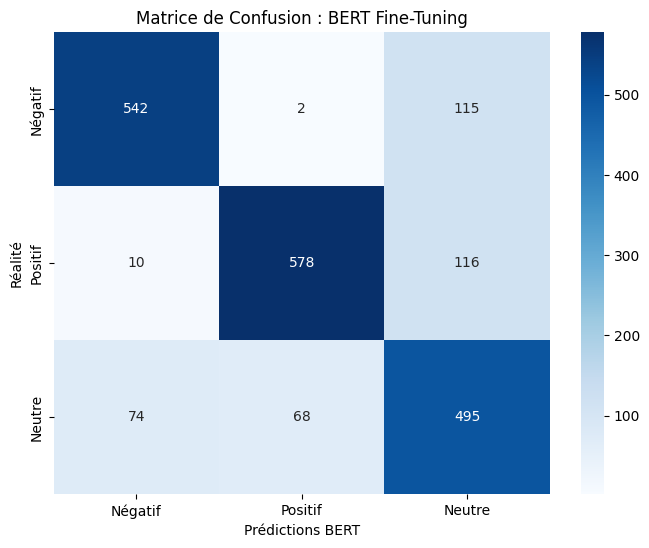

In [9]:
# Récupération des prédictions brutes pour le rapport détaillé
predictions = trainer.predict(tokenized_full["test"])
y_pred = predictions.predictions.argmax(-1) # Convertit les scores en labels (0, 1, 2)
y_true = predictions.label_ids # Récupère les vrais labels

# Affichage du rapport de classification
print("\n--- RAPPORT DE CLASSIFICATION BERT ---")
print(classification_report(y_true, y_pred, target_names=['Négatif', 'Positif', 'Neutre']))

# Lance l'évaluation sur le jeu de test
eval_results = trainer.evaluate()

# Affiche les résultats proprement
print("--- Résultats de l'évaluation ---")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

# Calcul de la matrice
cm = confusion_matrix(y_true, y_pred)

# Visualisation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Négatif', 'Positif', 'Neutre'], 
            yticklabels=['Négatif', 'Positif', 'Neutre'])
plt.xlabel('Prédictions BERT')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion : BERT Fine-Tuning')
plt.show()

Sauvegarde du modèle 

In [10]:
# Sauvegarde le modèle et le tokenizer dans un dossier local
model.save_pretrained("./mon_modele_bert_final")
tokenizer.save_pretrained("./mon_modele_bert_final")
print("Modèle sauvegardé avec succès.")

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Modèle sauvegardé avec succès.
